# Jumba Demo 001

## Sum of first X integers

Given this simple function:

$$sum(x) = \sum\limits_{x=0}^X x$$

The we define $sum_p(x)$ in pure Python.

Then we define $sum_j(x)$ that is identical but just with decorator `@jit` in the definition.

In [1]:
def sum_p(X):
    y = 0
    for x_i in range(int(X)):
        y += x_i
    return y

from numba import jit

@jit
def sum_j(X):
    y = 0
    for x_i in range(int(X)):
        y += x_i
    return y

Lets define a benchmark to study perfromances of our implementations of $sum(x)$:

In [2]:
import os
import time
import pandas as pd
import matplotlib
%matplotlib inline

# Different platforms require different functions to properly measure current timestamp:
if os.name == 'Windows':
    now = time.clock
else:
    now = time.time

def run_benchmarks(functions, call_parameters, num_times,
                   logy=False, logx=False):
    
    # Executes one function several times and measure performances:
    def _apply_function(function, num_times):
        for j in range(num_times):
            t_0 = now()
            y = function(*call_parameters)
            duration = (now() - t_0)
            yield float(duration)
    
    # Execute all functions the requested number of times and collects durations:
    def _apply_functions(functions, num_times):
        for function in functions:
            yield pd.Series(_apply_function(function, num_times),
                            name=function.__name__)
            
    # Collects and plots the results:
    df = pd.concat(_apply_functions(functions, num_times),
                   axis=1)
    df.plot(figsize=(10,5),
            logy=logy,
            logx=logx,
            title='$T[f(x)]$ in seconds',
            style='o-')


Lets measure them:

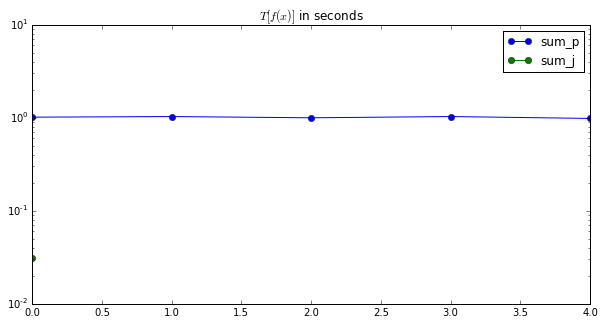

In [3]:
run_benchmarks(functions=[sum_p, sum_j],
               call_parameters=(10000000,),
               num_times=5,
               logy=True) # Logarithmic scale

A second run to study `numba` caching mechanism

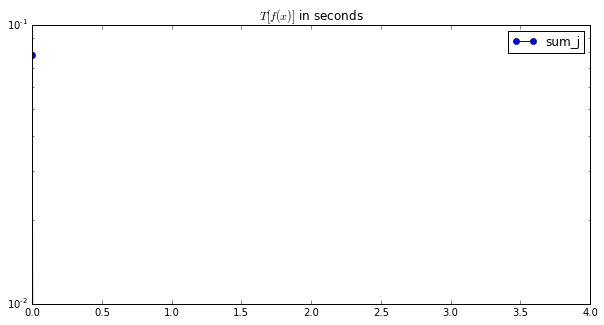

In [4]:
run_benchmarks(functions=[sum_j],
               call_parameters=(1000000000000000.,),
               num_times=5,
               logy=True) # Logarithmic scale

Numba JIT functionality works in the following way:
- At each call of a function $f(x)$, numba looks if the type $T$ of $x$.
- If it is the first time that type have been used generates a native implementation $f_T(x)$.
- If it is not  the first time that type have been used generates fetches the native implementation from a cache.
- Numba executes $f_T(x)$ that is orders of magnitudes faster than a pure Python implementation.

##And what about adding Cython to the game?

Lets define the same functon, but tuned to operate with floats:

$$sum(x) = \sum\limits_{x=0}^X x$$

We define it using `numba` and `cython`:

In [5]:
from numba import jit

@jit
def sum_j(x):
    y = 0.
    x_i = 0.
    while x_i < x:
        y += x_i
        x_i += 1.
    return y

In [6]:
%load_ext Cython

In [7]:
%%cython
def sum_c(double x):
    cdef double y = 0.
    cdef double x_i = 0.
    while x_i < x:
        y += x_i
        x_i += 1.
    return y

Cython generates C code from a python code and optionally let the developer to select types for the variables. In the example we have chosen to restrict our function to C integers.

It is fast because C code is generated, compiled and executed.

But the code is more decorated and have a narrower scope comparing to the usage of `numba`

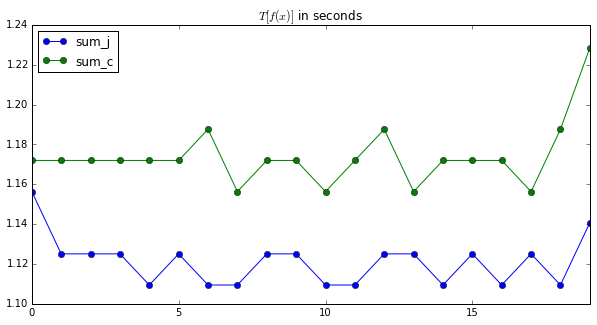

In [8]:
run_benchmarks(functions=[sum_j, sum_c],
               call_parameters=(1000000000.,),
               num_times=20) # Logarithmic scale

The `numba` jitted function is comparable with the *cythonized* one, lets check what was the C code `cython` used, just to give us an idea of the efficiency of the code generated.

In [9]:
%%cython --annotate
def sum_c(double x):
    cdef double y = 0.
    cdef double x_i = 0.
    while x_i < x:
        y += x_i
        x_i += 1.
    return y

The function is in order, we have Python overhead only during the call and the return value to convert values from/to Python.